# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

In [5]:
train_df = pd.DataFrame(train_X)
train_df['y'] = train_y
train_df

,0,1,2,3,4,5,6,7,8,9,...,3064,3065,3066,3067,3068,3069,3070,3071,3072,y
0,-0.089754,-0.035684,0.089948,-0.093667,-0.040285,0.084531,-0.097578,-0.049002,0.074858,-0.109567,...,-0.046039,0.084531,-0.120953,-0.035040,0.100906,-0.126547,-0.039985,0.097104,1.0,9
1,0.016129,0.019218,0.054654,0.012215,0.010696,0.049236,0.000461,-0.001943,0.039564,-0.027214,...,-0.081333,-0.056645,-0.128796,-0.113472,-0.087329,-0.150077,-0.134103,-0.106818,1.0,9
2,-0.254460,-0.329802,-0.368875,-0.254452,-0.330481,-0.370371,-0.254441,-0.331355,-0.372201,-0.254665,...,-0.265647,-0.280175,-0.187619,-0.235040,-0.252035,-0.169685,-0.204691,-0.232308,1.0,2
3,0.114168,0.160394,0.089948,0.212215,0.253833,0.174727,0.063206,0.052959,0.027799,-0.125253,...,0.232392,0.194335,0.181008,0.227705,0.191102,0.183256,0.230603,0.199065,1.0,1
4,0.125933,0.132943,0.066419,0.118097,0.124421,0.057080,0.118108,0.123547,0.055250,0.117884,...,0.130431,0.088453,0.133949,0.133587,0.081298,0.124433,0.124720,0.077496,1.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,-0.250538,-0.172939,-0.235542,-0.270138,-0.173618,-0.237038,-0.281892,-0.166649,-0.234946,-0.266429,...,0.036314,0.002178,-0.050364,0.047313,0.014632,-0.044195,0.058054,0.030437,1.0,1
8996,0.184756,0.191767,0.180144,0.172999,0.179323,0.166884,0.165167,0.166684,0.161133,0.180629,...,0.040235,0.029629,0.075126,0.066920,0.065612,0.089139,0.085505,0.089261,1.0,7
8997,0.380835,0.368237,0.360536,0.420058,0.414617,0.398256,0.451441,0.452959,0.431721,0.427688,...,0.224549,0.210021,0.216302,0.231626,0.218553,0.214629,0.230603,0.218673,1.0,4
8998,-0.242695,-0.223920,-0.129660,-0.242687,-0.220677,-0.123313,-0.242676,-0.221551,-0.125142,-0.250743,...,-0.163686,-0.154685,-0.132717,-0.156609,-0.146153,-0.114783,-0.141946,-0.130347,1.0,2


# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [105]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [74]:
# preds = np.array([[10, 0, 5],
#                   [11, 0, 6],
#                   [1, 2, 3]])

# preds -= np.max(preds, axis=-1)[..., None]
# print(preds)
# denominator = np.sum(preds, axis=-1)[..., None]
# print(denominator)
# preds / denominator

[[  0 -10  -5]
 [  0 -11  -5]
 [ -2  -1   0]]
[[-15]
 [-16]
 [ -3]]


array([[-0.        ,  0.66666667,  0.33333333],
       [-0.        ,  0.6875    ,  0.3125    ],
       [ 0.66666667,  0.33333333, -0.        ]])

In [106]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [107]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [108]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [110]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [118]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(float)
target_index = np.ones(batch_size, dtype=int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [122]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [150]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=0.001, batch_size=300, reg=0.001)

Epoch 0, loss: 82.530609
Epoch 1, loss: 89.268281
Epoch 2, loss: 86.261790
Epoch 3, loss: 80.517171
Epoch 4, loss: 84.441692
Epoch 5, loss: 82.701363
Epoch 6, loss: 80.453971
Epoch 7, loss: 85.065395
Epoch 8, loss: 83.985147
Epoch 9, loss: 87.921253


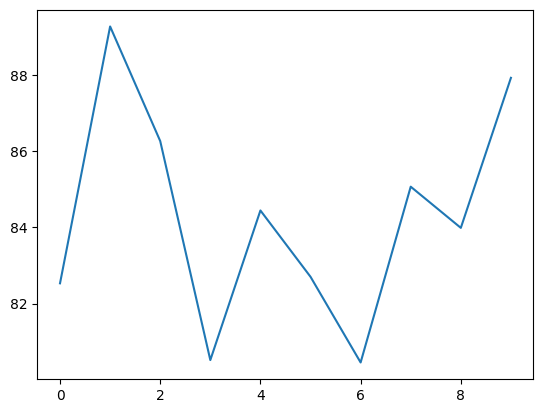

In [151]:
# let's look at the loss history!
plt.plot(loss_history)

In [153]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 1000 epochs: ", accuracy)

Accuracy:  0.189
Epoch 0, loss: 87.661245
Epoch 10, loss: 89.801733
Epoch 20, loss: 86.950352
Epoch 30, loss: 90.190402
Epoch 40, loss: 86.208589
Epoch 50, loss: 89.484593
Epoch 60, loss: 90.972414
Epoch 70, loss: 86.814674
Epoch 80, loss: 88.365122
Epoch 90, loss: 84.533032
Accuracy after training for 1000 epochs:  0.159


### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [160]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = 0

# TODO use validation set to find the best hyperparameters
for lr in learning_rates:
    for reg in reg_strengths:
        print(f'LR={lr}, REG={reg}')
        clf = linear_classifer.LinearSoftmaxClassifier()
        loss_history = clf.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=300, reg=reg)
        pred = clf.predict(val_X)
        val_accuracy = multiclass_accuracy(pred, val_y)
        print(f'Val Accuracy: {val_accuracy}\n\n')
        if val_accuracy > best_val_accuracy:
            best_classifier = clf
            best_val_accuracy = val_accuracy
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

print('best validation accuracy achieved: %f' % best_val_accuracy)

LR=0.001, REG=0.0001
Epoch 10, loss: 83.983876
Epoch 20, loss: 81.863251
Epoch 30, loss: 86.123867
Epoch 40, loss: 81.899523
Epoch 50, loss: 77.732218
Epoch 60, loss: 75.716447
Epoch 70, loss: 78.282408
Epoch 80, loss: 81.528457
Epoch 90, loss: 82.204212
Epoch 100, loss: 71.877113
Epoch 110, loss: 76.661587
Epoch 120, loss: 76.456842
Epoch 130, loss: 71.773772
Epoch 140, loss: 73.030013
Epoch 150, loss: 74.371440
Epoch 160, loss: 72.434901
Epoch 170, loss: 72.518900
Epoch 180, loss: 71.189721
Epoch 190, loss: 71.615462
Epoch 200, loss: 76.238169
Val Accuracy: 0.21


LR=0.001, REG=1e-05
Epoch 10, loss: 83.198787
Epoch 20, loss: 78.916223
Epoch 30, loss: 79.455671
Epoch 40, loss: 77.530992
Epoch 50, loss: 76.307011
Epoch 60, loss: 78.339838
Epoch 70, loss: 75.122114
Epoch 80, loss: 76.018421
Epoch 90, loss: 79.510448
Epoch 100, loss: 79.290129
Epoch 110, loss: 81.211066
Epoch 120, loss: 75.300544
Epoch 130, loss: 71.495285
Epoch 140, loss: 76.362785
Epoch 150, loss: 76.282619
Epoch 160, 

# Какой же точности мы добились на тестовых данных?

In [168]:
test_pred = best_classifier.predict(test_X)
# clf1 = linear_classifer.LinearSoftmaxClassifier()
# loss_history = clf1.fit(train_X, train_y, epochs=200, learning_rate=0.0001, batch_size=300, reg=0.0001)
# test_pred = clf1.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.208000
